# Forest Cover Classification

Broad aim: to use deep learning to predict forest cover type (the most common kind of tree cover) based only on cartographic variables. 

The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. The covertypes are the following:

- Spruce/Fir
- Lodgepole Pine
- Ponderosa Pine
- Cottonwood/Willow
- Aspen
- Douglas-fir
- Krummholz

Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is raw and has not been scaled or preprocessed. It contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so existing forest cover types are mainly a result of ecological processes rather than forest management practices.

Project Objectives:
- Develop one or more classifiers for this multi-class classification problem.
- Use TensorFlow with Keras to build your classifier(s).
- Use your knowledge of hyperparameter tuning to improve the performance of your model(s).
- Test and analyze performance.
- Create clean and modular code.


In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

2024-05-14 07:12:32.529985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 07:12:32.530134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 07:12:32.672457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory analysis

In [2]:
data = pd.read_csv('../input/forest-cover-type-dataset/covtype.csv')

In [3]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

Description of columns, attributes:
1. Elevation: 1 column
2. Aspect: 1 column
3. Slope: 1 column
4. Horizontal_Distance_To_Hydrology: Horizontal distance to nearest surface water features: 1 column
5. Vertical_Distance_To_Hydrology: Vertical distance to nearest surface water features: 1 column
6. Horizontal_Distance_To_Roadways: Horizontal distance to nearest roadways: 1 column
7. Hillshade_9am: Hillshade index at 9AM: 1 column
8. Hillshade_Noon: Hillshade index at noon: 1 column
9. Hillshade_3pm: Hillshade index at 3PM: 1 column
10. Horizontal_Distance_To_Fire_Points: Horizontal distance to nearest wildfire ignition points: 1 column
11. Wilderness_Area: 4 binary columns. 0 indicates absent and 1 indicates present: 4 columns
12. Soil_Type: 40 binary columns. 0 indicates absent and 1 indicates present: 40 columns
13. Cover_Type: 7 forest cover types: 7 columns

In [5]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [6]:
# Labels column is Cover_Type: check unique values and their frequency
data['Cover_Type'].value_counts()

Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

<Axes: xlabel='Cover_Type', ylabel='count'>

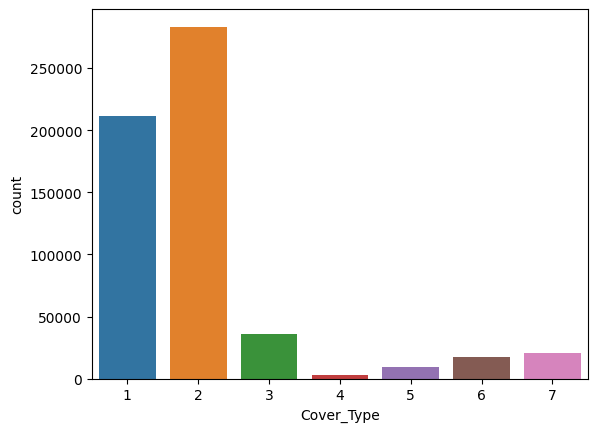

In [7]:
sns.countplot(data=data, x='Cover_Type')

In [8]:
data.shape

(581012, 55)

In [9]:
# Check for duplicate rows
duplicates = data.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [10]:
data.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


The dataset doesnt have null values nor duplicates

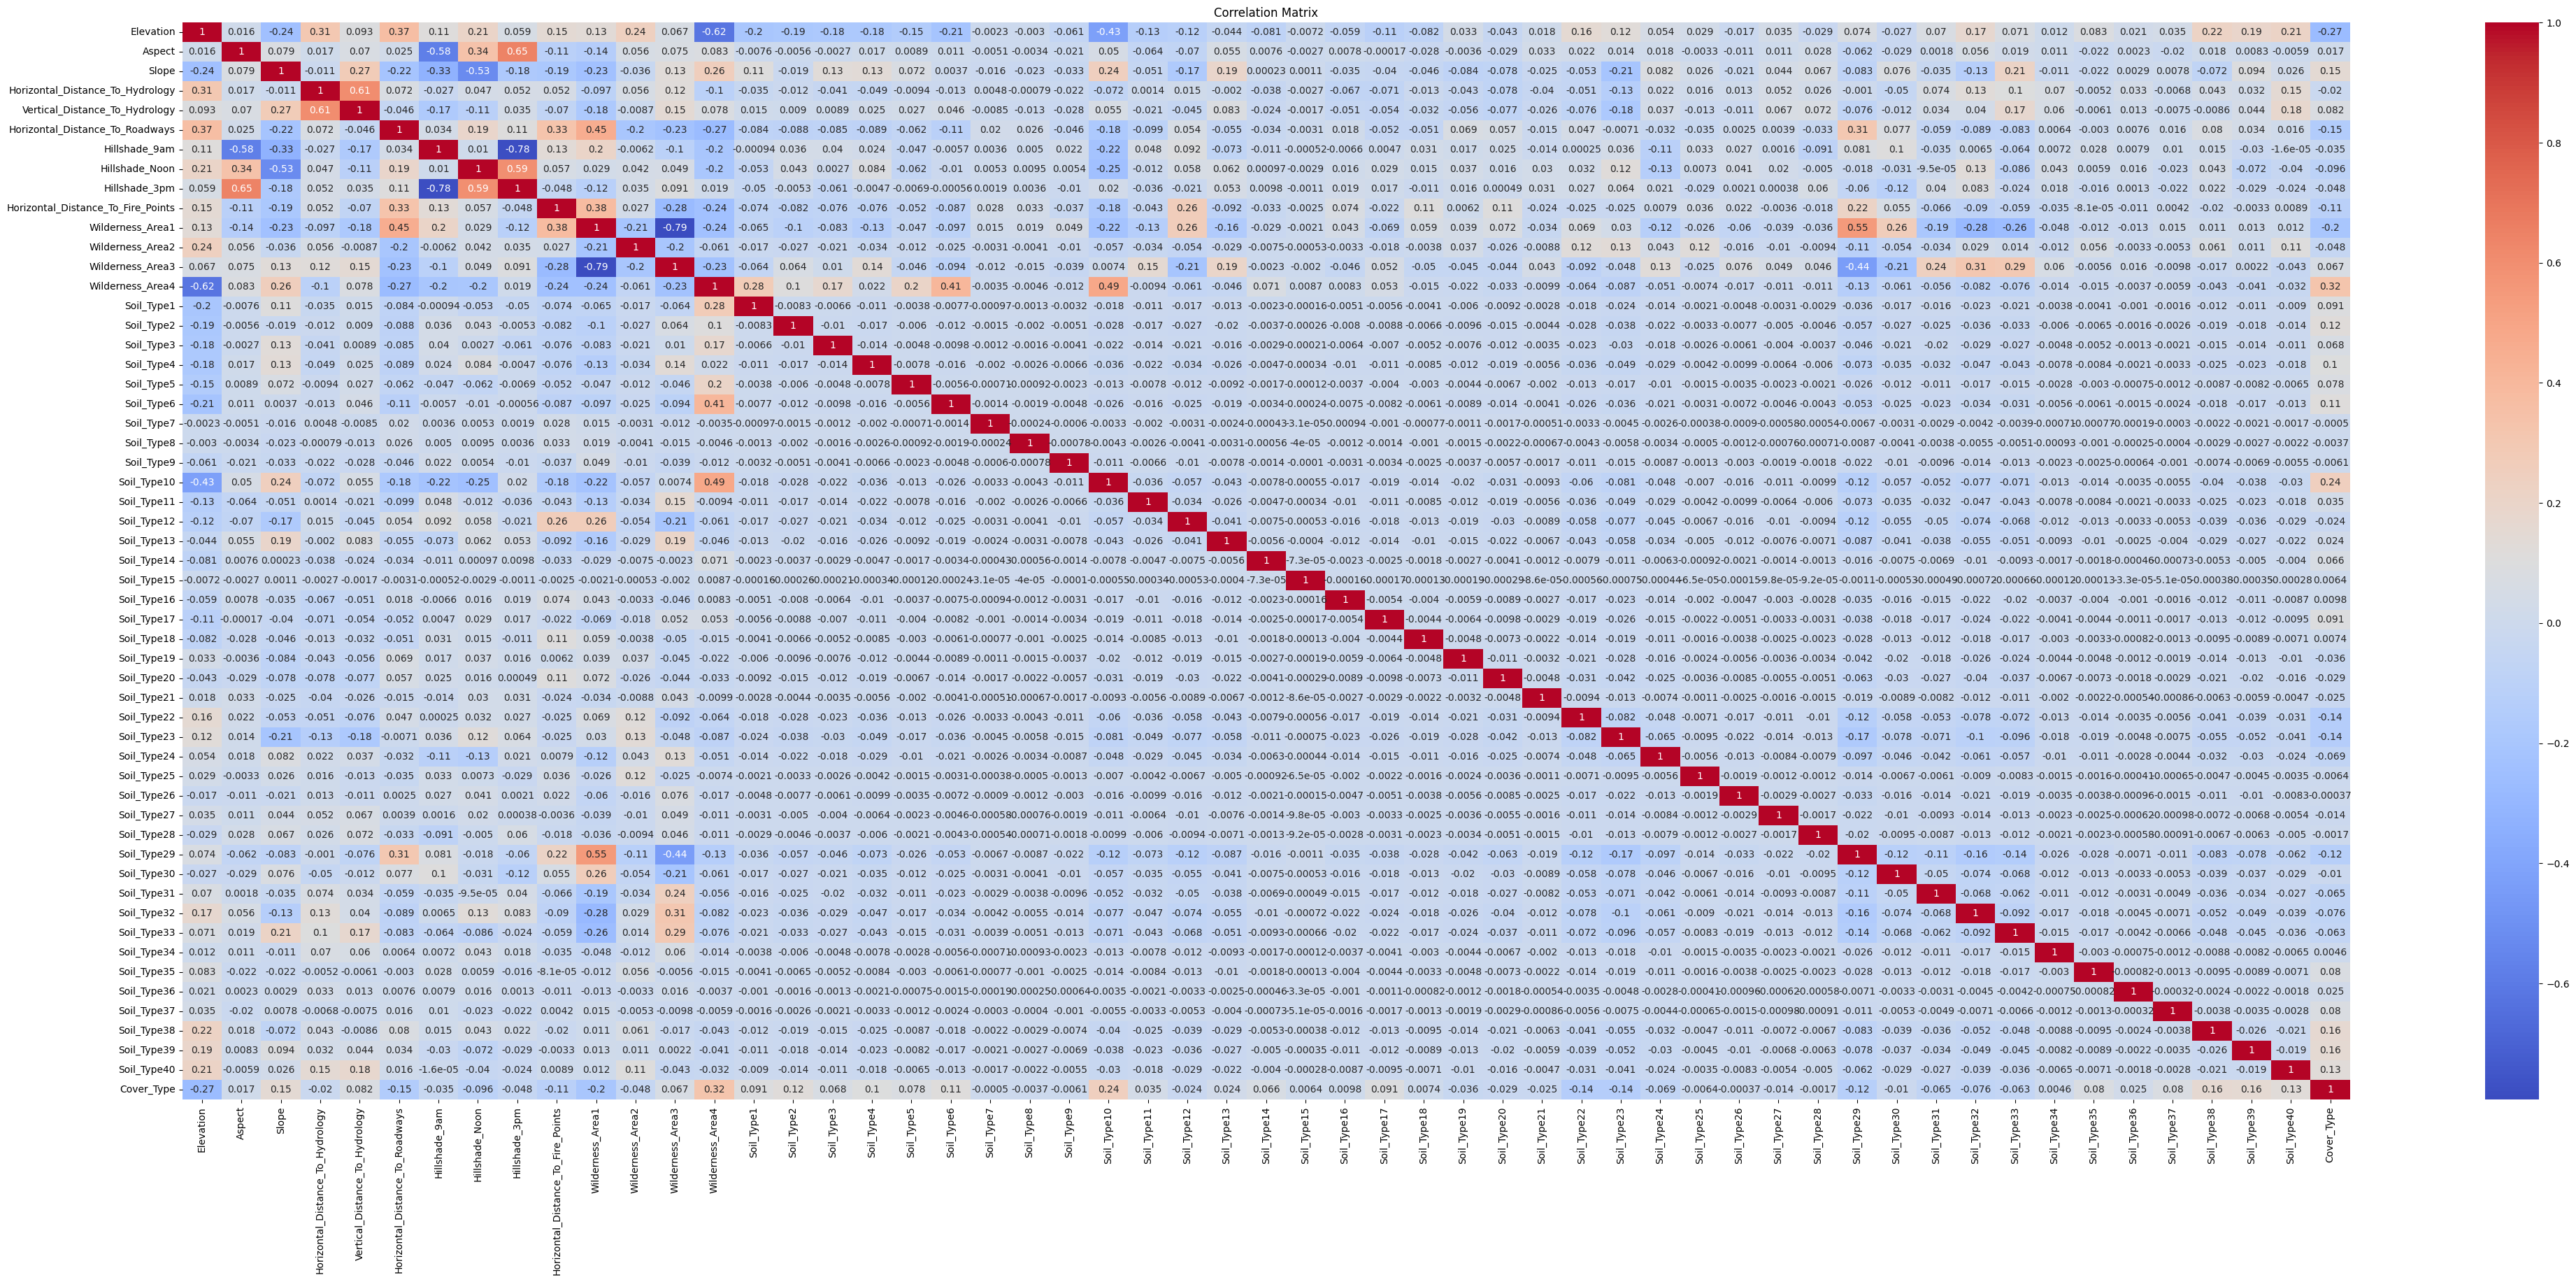

In [11]:
# heatmap of the correlation matrix
plt.figure(figsize=(50, 20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Model

There are 7 output classes, we have a multiclass classification problem so we'll use categorical cross-entropy for the loss function.

Classes are imbalanced, so we'll use SMOTE in the training set.

In [12]:
# Prepare features and labels
features = data.iloc[:, 0:-1]
labels = data.iloc[:, -1] #cover type

In [13]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [14]:
# apply standard scaling after the split to avoid data leakage.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)       

In [15]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [16]:
# define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    min_delta=0.001,        # Minimum change to qualify as an improvement
    patience=10,            # Stop after 10 epochs without improvement
    verbose=1,              # Print progress
    restore_best_weights=True  # Restore the best weights
)


In [17]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')  
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model with early stopping
history = model.fit(
    X_train_smote, 
    y_train_smote, 
    epochs=50, 
    validation_split=0.1,
    callbacks=[early_stopping]  
)


Epoch 1/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.8195 - loss: 0.4407 - val_accuracy: 0.9421 - val_loss: 0.1896
Epoch 2/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.9194 - loss: 0.2101 - val_accuracy: 0.9788 - val_loss: 0.0785
Epoch 3/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.9338 - loss: 0.1751 - val_accuracy: 0.9874 - val_loss: 0.0464
Epoch 4/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - accuracy: 0.9405 - loss: 0.1583 - val_accuracy: 0.9533 - val_loss: 0.1302
Epoch 5/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9453 - loss: 0.1464 - val_accuracy: 0.9713 - val_loss: 0.0879
Epoch 6/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9479 - loss: 0.1389 - val_accuracy: 0.9454 - val_loss: 0.1521
Epoch 7/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9507 - loss: 0.1319 - val_accuracy: 0.9508 - val_loss: 0.1435
Epoch 8/50
44620/44620 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - accuracy: 

# Evaluation

In [20]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9077 - loss: 0.2503
Test Loss: 0.2536308169364929
Test Accuracy: 90.83%


In [21]:
# This line will print all keys in the history object
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

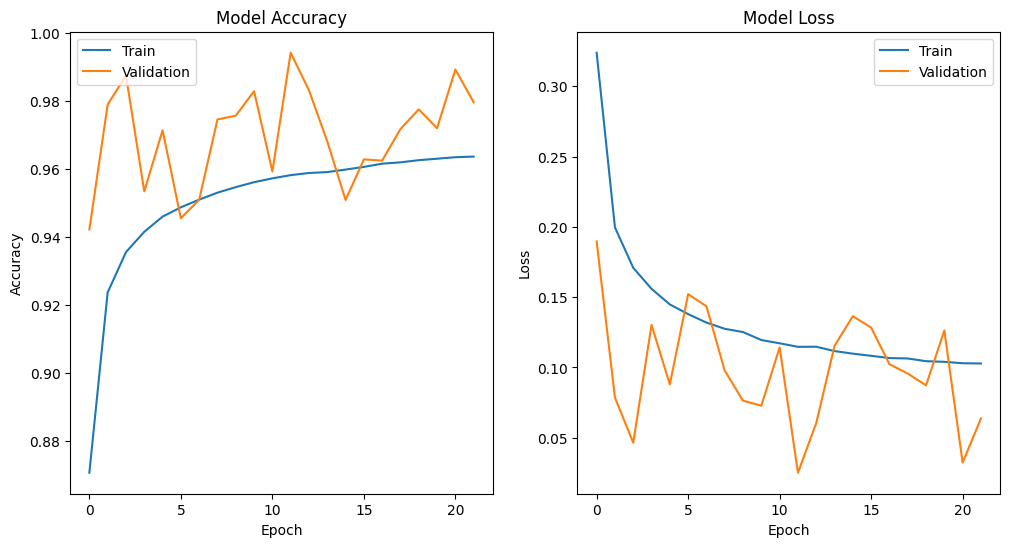

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')  # Ensure 'accuracy' is the correct key
plt.plot(history.history['val_accuracy'], label='Validation')  # Ensure 'val_accuracy' is the correct key
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')  # Ensure 'loss' is the correct key
plt.plot(history.history['val_loss'], label='Validation')  # Ensure 'val_loss' is the correct key
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [23]:
# Predict classes with the model
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [24]:
# Generate a classification report
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.90      0.90     42368
           2       0.94      0.90      0.92     56661
           3       0.94      0.94      0.94      7151
           4       0.76      0.93      0.84       549
           5       0.63      0.96      0.76      1899
           6       0.84      0.93      0.88      3473
           7       0.75      0.99      0.85      4102

    accuracy                           0.91    116203
   macro avg       0.82      0.94      0.87    116203
weighted avg       0.91      0.91      0.91    116203



In [25]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[38234  2886     3     1   112    26  1106]
 [ 3877 50970   247     0   924   380   263]
 [    4    60  6717   126    52   192     0]
 [    0     0    30   513     0     6     0]
 [   10    42     3     0  1831    13     0]
 [    5    25   172    38     8  3225     0]
 [   43     5     0     0     1     0  4053]]


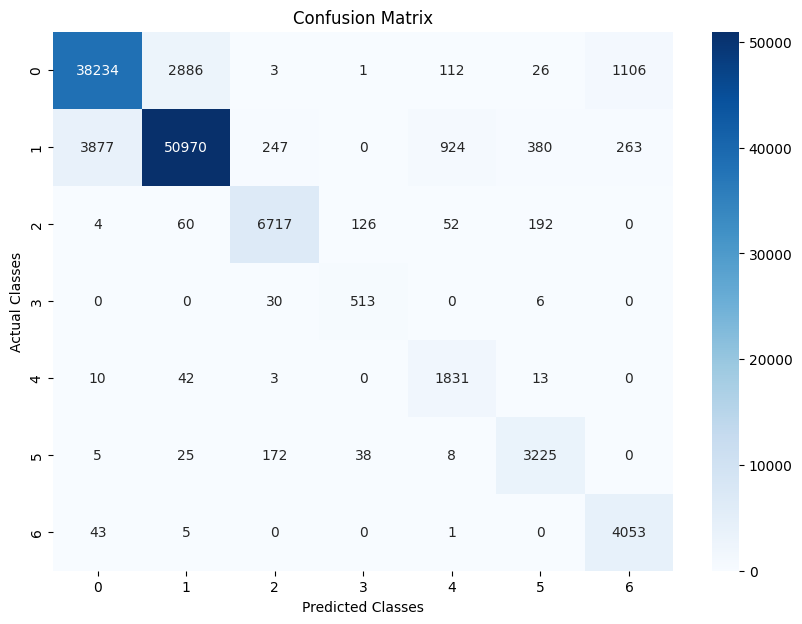

In [26]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.title("Confusion Matrix")
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()


# Interpretation of results

The final test accuracy of 91.51% and a loss of 0.2420 are very good, indicating strong predictive performance. It aligns well with the validation accuracy, suggesting that the validation set was a good representative of the test set and that the model has generalized well.

Across most classes, both precision and recall are high, suggesting that the model performs well in identifying all classes and does not suffer from significant bias or skew. Lower scores in class 5 for precision (0.61) indicate that while the model predicts this class frequently and almost always correctly (recall of 0.97), it also mistakenly predicts this class when it's not the case (false positives). This could be an area to improve.

Regarding the confusion matrix, most values are on the diagonal, which indicates correct classifications are predominant. Misclassifications are captured off the diagonal. For instance, class 1 and 2 have considerable confusion, which might indicate similar feature representations or insufficient distinctive features learned by the model.

Next steps:
- Modify model's architecture.
- Add Batch Normalization to help stabilise the learning process and drastically reduce the number of training epochs required to train deep networks.
- Add Dropout: A form of regularisation used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.
- Optimise hyperparameters like optimiser and learning rate.

Overall, this is a good model to predict forest cover types.